### Carga de datos

In [1]:
import pandas as pd
import numpy as np
 
data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Entrenamiento del modelo

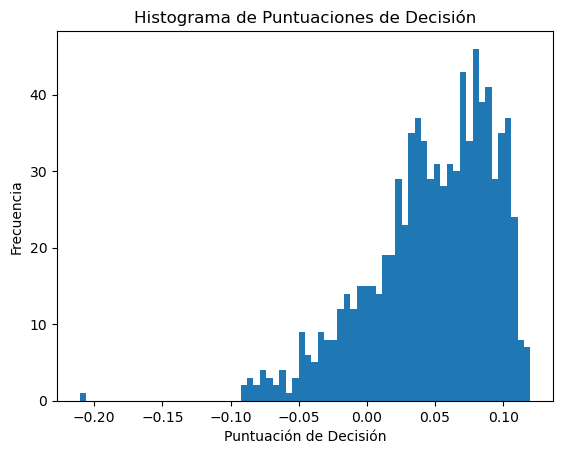

In [3]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Inicializa el modelo Isolation Forest
iForest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=40) 

# Ajusta el modelo a los datos
iForest.fit(data_train)

# Calcula las puntuaciones de anomalía para cada observación
scores_train = iForest.decision_function(data_train)

plt.hist(scores_train, bins=70)
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

C:\Users\djime\AppData\Local\Temp\ipykernel_23052\4153140210.py:17: RuntimeWarning: invalid value encountered in scalar divide
  PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)


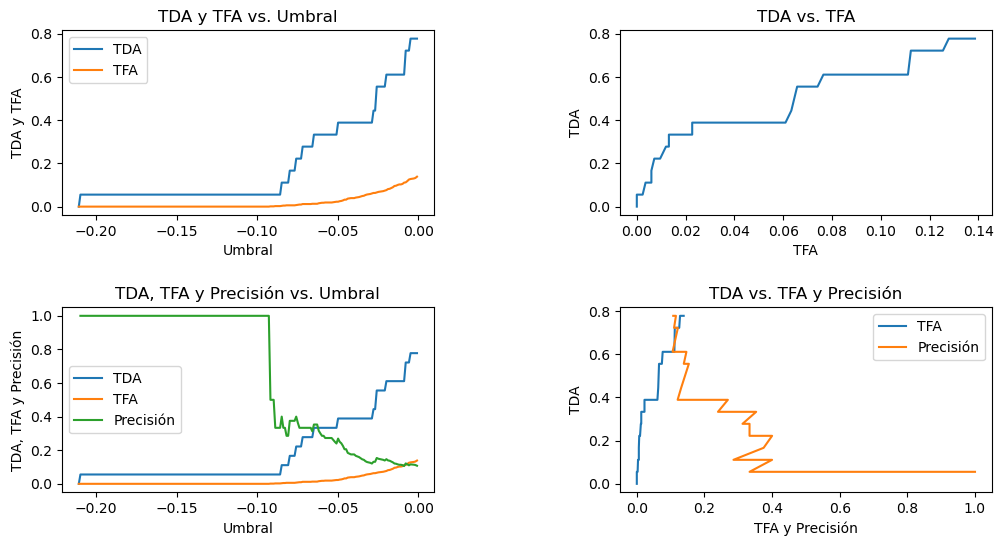

In [4]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(scores_train), 0, 0.001)
tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(scores_train < umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(umbral, tda, label='TDA')
ax1.plot(umbral, tfa, label='TFA')
ax1.set_xlabel('Umbral')  
ax1.set_ylabel('TDA y TFA') 
ax1.set_title('TDA y TFA vs. Umbral')
ax1.legend()

ax2.plot(tfa, tda)
ax2.set_xlabel('TFA')  
ax2.set_ylabel('TDA')  
ax2.set_title('TDA vs. TFA')

ax3.plot(umbral, tda, label='TDA')
ax3.plot(umbral, tfa, label='TFA')
ax3.plot(umbral,precis,label='Precisión')
ax3.set_xlabel('Umbral')  
ax3.set_ylabel('TDA, TFA y Precisión') 
ax3.set_title('TDA, TFA y Precisión vs. Umbral')
ax3.legend()

ax4.plot(tfa,tda,label='TFA')
ax4.plot(precis, tda, label='Precisión')
ax4.set_xlabel('TFA y Precisión') 
ax4.set_ylabel('TDA') 
ax4.set_title('TDA vs. TFA y Precisión')
ax4.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Selección manual de valores de TDA y TFA

<IPython.core.display.Javascript object>


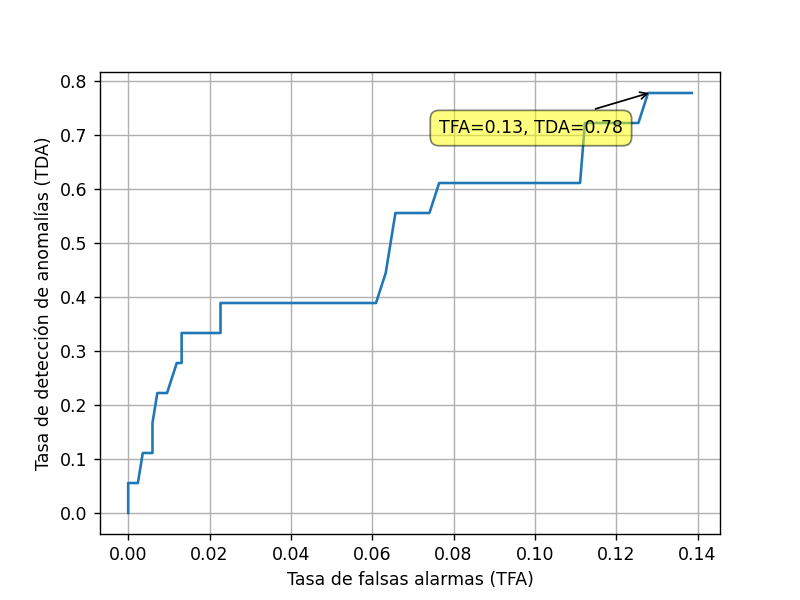

In [5]:
%matplotlib notebook
import mplcursors

fig, ax = plt.subplots()
ax.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)
# Habilitar la selección de puntos
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f'TFA={sel.target[0]:.2f}, TDA={sel.target[1]:.2f}'))
cursor.connect("add", lambda sel: sel.annotation.draggable(True))

plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [9]:
from sklearn.metrics import classification_report

valor_tfa = input("Valor de TFA: ")
valor_tda = input("Valor de TDA: ")
valor_tfa=float(valor_tfa)
valor_tda=float(valor_tda)

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")

anomalias = data_train[scores_train < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_train < umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

Valor de TFA (x): 0.13
Valor de TDA (y): 0.78
Umbral para la decisión: -0.0027604723328606973
-----------------------------------------------------------------------
Número de anomalías detectadas: 123
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       837
           1       0.11      0.78      0.20        18

    accuracy                           0.87       855
   macro avg       0.55      0.82      0.56       855
weighted avg       0.98      0.87      0.91       855

------------------------------------------------------------------------
[[728 109]
 [  4  14]]
VP: 14
FP: 109
VN: 728
FN: 4
------------------------------------------------------------------------
TDA: 0.7777777777777778
TFA: 0.13022700119474312
Precision: 0.11382113821138211
F1: 0.19858156028368795


### Análisis y resultados en la validación (data_test)

<IPython.core.display.Javascript object>


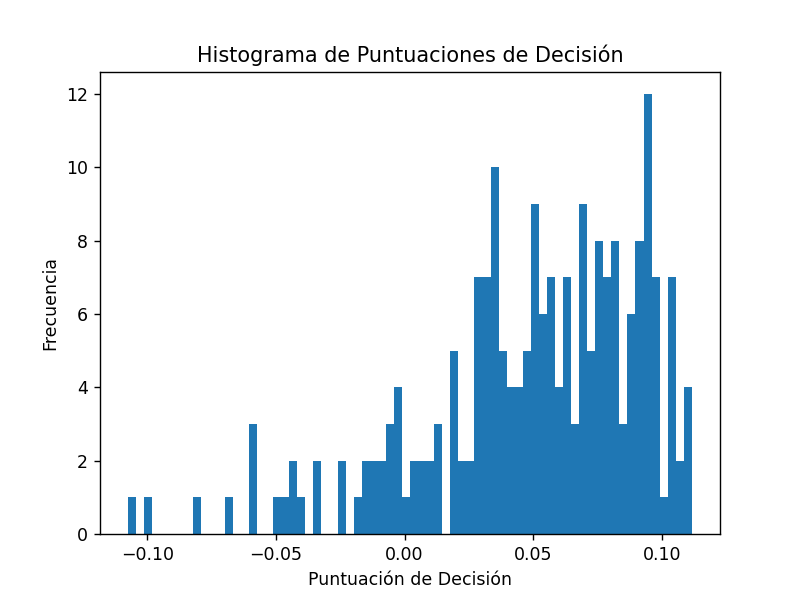

Número de anomalías detectadas: 29
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       204
           1       0.31      0.90      0.46        10

    accuracy                           0.90       214
   macro avg       0.65      0.90      0.70       214
weighted avg       0.96      0.90      0.92       214

------------------------------------------------------------------------
[[184  20]
 [  1   9]]
VP: 9
FP: 20
VN: 184
FN: 1
------------------------------------------------------------------------
TDA: 0.9
TFA: 0.09803921568627451
Precision: 0.3103448275862069
F1: 0.4615384615384615


In [16]:
scores_test = iForest.decision_function(data_test)

plt.hist(scores_test, bins=70)
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.show()

anomalias = data_test[scores_test < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_test < umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1] 
FP = cm[0, 1] 
VN = cm[0, 0] 
FN = cm[1, 0]
print("VP:",VP) 
print("FP:",FP) 
print("VN:",VN) 
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN) 
TFA=FP/(VN+FP) 
Precision=VP/(VP+FP) 
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

### Ajuste fino del umbral 

In [17]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[scores_train < umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(scores_train < umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[scores_test < umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(scores_test < umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)


Valor del umbral:-0.00276
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 123
------------------------------------------------------------------------
[[728 109]
 [  4  14]]
VP: 14
FP: 109
VN: 728
FN: 4
------------------------------------------------------------------------
TDA: 0.7777777777777778
TFA: 0.13022700119474312
Precision: 0.11382113821138211
F1: 0.19858156028368795
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 29
------------------------------------------------------------------------
[[184  20]
 [  1   9]]
VP: 9
FP: 20
VN: 184
FN: 1
------------------------------------------------------------------------
TDA: 0.9
TFA: 0.09803921568627451
Precision: 0.3103448275862069
F1: 0.4615384615384615
